# 0. 기본 세팅

In [1]:
# 데이터 전처리
import pandas as pd
import numpy as np
from datetime import datetime

# 시각화 (seaborn, matplotlib)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 시각화 (plotly)
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
# !apt -qq -y install fonts-nanum

In [3]:
# 한글 폰트를 사용하기 위한 코드
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 1. 주식 데이터 가져오기

In [4]:
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 17.5 MB/s eta 0:00:00


In [5]:
# 네이버 증권에서 삼성전자 주식 정보 가져오기
from pykrx import stock
# 기간: 1995/01/02 ~ 2022/09/15, 삼성전자 Ticker 번호: 005930
stock = stock.get_market_ohlcv_by_date("19950102", "20220915", "005930")

In [6]:
# 데이터 확인하기
stock

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
1995-05-02,1564,1564,1531,1544,139560,16676735000,-0.83
1995-05-03,1544,1635,1544,1596,382980,47649710000,3.35
1995-05-04,1602,1609,1576,1583,175590,21609210000,-0.81
1995-05-06,1576,1596,1576,1576,47440,5810535000,-0.41
1995-05-08,1576,1576,1557,1564,91810,11127115000,-0.82
...,...,...,...,...,...,...,...
2022-09-07,56700,56700,55900,56000,17384854,975695179700,-1.93
2022-09-08,56200,56400,55600,55600,18000016,1006366398000,-0.71
2022-09-13,57000,58500,56800,58100,17166581,991015891355,4.50


# 2. 데이터 확인하기

## 2.1 기본 정보 확인

In [7]:
# 데이터 요약정보 확인하기
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6928 entries, 1995-05-02 to 2022-09-15
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      6928 non-null   int32  
 1   고가      6928 non-null   int32  
 2   저가      6928 non-null   int32  
 3   종가      6928 non-null   int32  
 4   거래량     6928 non-null   int32  
 5   거래대금    6928 non-null   int64  
 6   등락률     6928 non-null   float32
dtypes: float32(1), int32(5), int64(1)
memory usage: 270.6 KB


In [8]:
# 결측치 확인하기
stock.isnull().sum()

시가      0
고가      0
저가      0
종가      0
거래량     0
거래대금    0
등락률     0
dtype: int64

* 주말에는 장이 열리지 않아서 데이터가 존재하지 않음 (따라서 따로 데이터를 제거하거나 처리해줄 필요 X)
* 결측치 없음

## 2.2 이상치 존재 여부 확인

In [9]:
# outlier 존재 여부 확인하기 (종가, 시가, 고가, 저가)
fig = go.Figure()
fig.add_trace(go.Box(x=stock['종가'], name='종가'))
fig.add_trace(go.Box(x=stock['시가'], name='시가'))
fig.add_trace(go.Box(x=stock['고가'], name='고가'))
fig.add_trace(go.Box(x=stock['저가'], name='저가'))
fig.show(renderer='colab')

In [10]:
# outlier 존재 여부 확인하기 (등락률)
fig = go.Figure()
fig.add_trace(go.Box(x=stock['등락률'], name='등락률'))
fig.show(renderer='colab')

In [11]:
# outlier 존재 여부 확인하기 (거래량) - 최대값이 지나치게 커서 의심스러움
fig = go.Figure()
fig.add_trace(go.Box(x=stock['거래량'], name='거래량'))
fig.show(renderer='colab')

In [12]:
# 거래량이 최대일 때의 데이터 확인
stock[stock['거래량'] == stock['거래량'].max()]

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2021-01-11,90000,96800,89500,91000,90306177,8379237727064,2.48


* 거래량(Volume)의 최대값이 지나치게 커서 outlier로 의심됨
    * 네이버 증권을 찾아보니 2021년 1월 11일 월요일에 삼성전자 주식은 최고가 및 최고 거래량을 기록했고, 이상 없는 데이터임이 확인됨

# 3. 시각화하기

## 3.1 추세 파악

In [13]:
# 삼성전자 종가 시각화하기
fig = go.Figure()

fig.add_trace(go.Scatter(x=stock.index, y=stock['종가'], mode='lines'))
fig.update_layout(title="종가(Close)", xaxis=dict({"title": "Date"}))
fig.show(renderer='colab')

In [14]:
# 전체적인 추세를 파악하기 위해 한 도표에 종가, 시가, 고가, 저가 모두 시각화하기
fig = go.Figure()
fig.add_trace(go.Scatter(x = stock.index, y = stock['종가'], name = '종가(Close)', mode='lines'))
fig.add_trace(go.Scatter(x = stock.index, y = stock['시가'], name = '시가(Open)', mode='lines'))
fig.add_trace(go.Scatter(x = stock.index, y = stock['고가'], name = '고가(High)', mode='lines'))
fig.add_trace(go.Scatter(x = stock.index, y = stock['저가'], name = '저가(Low)', mode='lines'))

fig.update_layout(
    {
        'title' : {'text':'삼성증권 KOSPI 지수 : 종가, 시가, 고가, 저가'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

* 전체적으로 상승 추세이지만 관측기간이 길어 오버랩이 많이 되었기 때문에, 특정 기간만 따로 추출해서 시각화하는 게 나을 것으로 판단됨

## 3.2 이동평균선

* .rolling() 함수를 사용해서 이동평균선을 계산할 수 있음

In [15]:
# rolling() 함수의 사용 예시
period = pd.period_range(start='2022-01-13 00:00:00',end='2022-01-13 02:30:00',freq='30T')
data = {'col1':[1,2,3,4,5,6],'col2':period}
idx = ['row1','row2','row3','row4','row5','row6']
df = pd.DataFrame(data= data, index = idx)

# 생성된 데이터프레임 확인
print(df)
# 현재 행 이전으로 window 크기만큼의 계산(sum)을 수행함
print(df.rolling(window=3).sum())

      col1              col2
row1     1  2022-01-13 00:00
row2     2  2022-01-13 00:30
row3     3  2022-01-13 01:00
row4     4  2022-01-13 01:30
row5     5  2022-01-13 02:00
row6     6  2022-01-13 02:30
      col1
row1   NaN
row2   NaN
row3   6.0
row4   9.0
row5  12.0
row6  15.0


### 3.2.1 이동평균 데이터 생성

In [16]:
# 5, 10, 20, 60, 120, 200일 이동평균 계산해서 각각의 컬럼으로 추가하기
stock['ma_5'] = stock['종가'].rolling(window=5).mean()
stock['ma_10'] = stock['종가'].rolling(window=10).mean()
stock['ma_20'] = stock['종가'].rolling(window=20).mean()
stock['ma_60'] = stock['종가'].rolling(window=60).mean()
stock['ma_120'] = stock['종가'].rolling(window=120).mean()
stock['ma_200'] = stock['종가'].rolling(window=200).mean()

stock

,시가,고가,저가,종가,거래량,거래대금,등락률,ma_5,ma_10,ma_20,ma_60,ma_120,ma_200
날짜,,,,,,,,,,,,,
1995-05-02,1564,1564,1531,1544,139560,16676735000,-0.83,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-03,1544,1635,1544,1596,382980,47649710000,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-04,1602,1609,1576,1583,175590,21609210000,-0.81,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-06,1576,1596,1576,1576,47440,5810535000,-0.41,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-08,1576,1576,1557,1564,91810,11127115000,-0.82,1572.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07,56700,56700,55900,56000,17384854,975695179700,-1.93,57220.0,58290.0,59200.0,59463.333333,63372.500000,68039.5
2022-09-08,56200,56400,55600,55600,18000016,1006366398000,-0.71,56660.0,57880.0,59025.0,59378.333333,63246.666667,67966.5
2022-09-13,57000,58500,56800,58100,17166581,991015891355,4.50,56780.0,57690.0,58935.0,59331.666667,63148.333333,67901.0


### 3.2.2 상관관계 분석

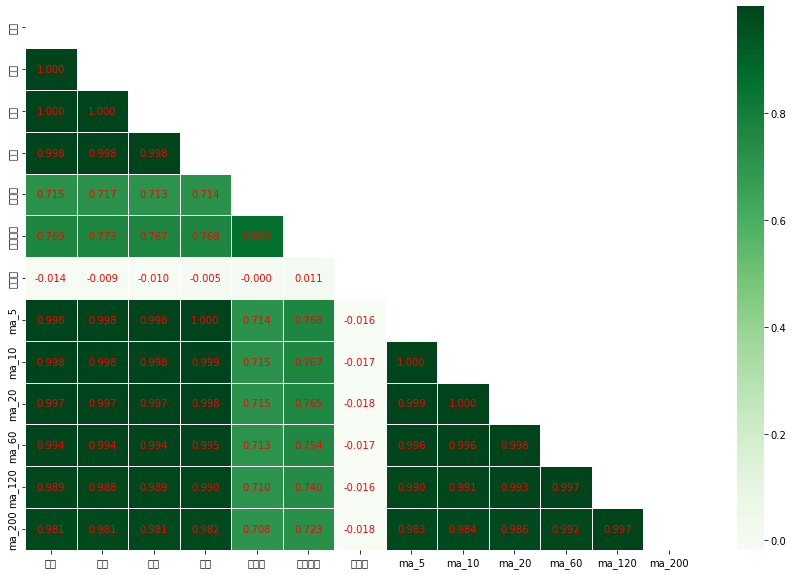

In [17]:
# 상관관계 히트맵 시각화
corr = stock.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, cmap="Greens", annot=True, linewidths=0.5, 
            annot_kws=dict(color='red'), fmt=".3f", cbar=True)
plt.show()

✅ <font color=green>**상관관계 분석 결과**</font>
* 종가, 시가, 고가, 저가는 각각의 이동평균선들과 0.98~0.99의 높은 양의 상관관계를 가짐 (거의 정비례)
* 거래량의 경우, 다른 컬럼들과 0.7 이상의 꽤 높은 양의 상관관계를 가짐
* 등락률(change)은 다른 컬럼들과 거의 0에 가까운 음의 상관관계를 가짐
<br><br>

✅ <font color=green>**결론**</font>
* 이동평균선은 주식 가격을 예측하는 것과 관계가 있다고 볼 수 있음
* 따라서 삼성전자의 코스피 지수를 예측할 때 종가와 이동평균선을 활용하기로 함

### 3.2.3 단기이평선, 장기이평선, 코스피지수 비교

In [18]:
# 실제 종가와 200일 장기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock.index, y=stock['종가'], name='종가(Close)', mode='lines', marker_color='blue'))
fig.add_trace(go.Scatter(x=stock.index, y=stock['ma_200'], name='200일 장기이평선', mode='lines', marker_color='red'))

fig.update_layout(
    {
        'title' : {'text':'종가, 200일 장기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

* 실제 종가와 200일 장기이평선을 비교한 결과, 전체적으로 장기이평선의 추세가 종가의 추세를 따라가고 있음

* 장기이평선이 종가보다 조금 뒤쪽에 형성되어 있는 것으로 보임

In [19]:
# 실제 종가와 20일 단기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock.index, y=stock['종가'], name='종가(Close)', mode='lines', marker_color='blue'))
fig.add_trace(go.Scatter(x=stock.index, y=stock['ma_20'], name='20일 단기이평선', mode='lines', marker_color='orange'))

fig.update_layout(
    {
        'title' : {'text':'종가, 20일 단기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

* 20일 차이이기 때문에, 실제 종가와 20일 단기이평선의 추세가 거의 비슷함

In [20]:
# 20일 단기이평선과 200일 장기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock.index, y=stock['ma_20'], name='20일 단기이평선', mode='lines', marker_color='orange'))
fig.add_trace(go.Scatter(x=stock.index, y=stock['ma_200'], name='200일 장기이평선', mode='lines', marker_color='red'))

fig.update_layout(
    {
        'title' : {'text':'단기이평선, 장기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

* 단기이평선과 장기이평선의 추세 차이도 크지 않음

* 앞서 언급했듯이, 전체 기간을 다 보는 게 아닌 특정 기간만 따로 추출해서 시각화하는 게 나을 것으로 판단됨

## 3.3 2019년 이후 코스피 지수

In [21]:
# 2019년 이후 데이터만 따로 추출
stock_2019 = stock[stock.index >= '2019-01-01']
stock_2019

,시가,고가,저가,종가,거래량,거래대금,등락률,ma_5,ma_10,ma_20,ma_60,ma_120,ma_200
날짜,,,,,,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,304682623050,0.13,38570.0,38730.0,39772.5,42162.500000,44111.666667,46395.70
2019-01-03,38300,38550,37450,37600,12471493,472966535350,-2.97,38330.0,38575.0,39490.0,42044.166667,44050.833333,46335.00
2019-01-04,37450,37600,36850,37450,14108958,525403005097,-0.40,38150.0,38430.0,39255.0,41919.166667,43982.916667,46273.55
2019-01-07,38000,38900,37800,38750,12748997,490833164150,3.47,38250.0,38395.0,39120.0,41810.000000,43920.000000,46209.00
2019-01-08,38000,39200,37950,38100,12756554,491578269750,-1.68,38130.0,38340.0,39000.0,41726.666667,43854.166667,46140.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07,56700,56700,55900,56000,17384854,975695179700,-1.93,57220.0,58290.0,59200.0,59463.333333,63372.500000,68039.50
2022-09-08,56200,56400,55600,55600,18000016,1006366398000,-0.71,56660.0,57880.0,59025.0,59378.333333,63246.666667,67966.50
2022-09-13,57000,58500,56800,58100,17166581,991015891355,4.50,56780.0,57690.0,58935.0,59331.666667,63148.333333,67901.00


In [22]:
# 2019년 이후의 실제 종가, 단기이평선, 장기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_2019.index, y=stock_2019['종가'], name='종가', mode='lines', marker_color='blue'))
fig.add_trace(go.Scatter(x=stock_2019.index, y=stock_2019['ma_20'], name='20일 단기이평선', mode='lines', marker_color='orange'))
fig.add_trace(go.Scatter(x=stock_2019.index, y=stock_2019['ma_200'], name='200일 장기이평선', mode='lines', marker_color='red'))

fig.update_layout(
    {
        'title' : {'text':'2019년 이후 종가, 단기이평선, 장기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

✅ <font color=green>**2019년 이후의 종가, 단기이평선, 장기이평선 비교 결과**</font>
* 2019년에서 2022년 9월 사이의 기간에 대해 시각화한 결과, 실제 종가와 200일 장기이평선의 추세 차이가 크게 나는 것을 알 수 있음

* 종가와 장단기 이동평균선 모두 전반적으로 상승하는 추세를 보이다가, 2022년에 들어서면서부터 우하향하기 시작함

* 특히 2020년 11월과 12월에 코스피가 급등했는데, 이는 코로나19 백신 개발과 대주주 요건 유지라는 호재가 투자심리 개선에 영향을 미쳤기 때문이라는 분석이 있음

* 단기이평선이 장기이평선보다 위에 있는 경우 주가가 상승하고, 반대인 경우 주가가 하락하는 것이 확인됨 (→ 투자이론과 일치함)

✅ <font color=green>**결론**</font>
* 가장 최근인 2022년의 두 이동평균선 사이의 간격이 꽤 차이나므로, 이후 코스피 지수도 당분간 하향하는 추세를 보이거나 그렇게 빠르게 회복되진 않을 것으로 예상됨

## 3.4 2022년의 코스피 지수

In [23]:
# 2022년 데이터만 따로 추출
stock_2022 = stock[stock.index >= '2022-01-01']
stock_2022

,시가,고가,저가,종가,거래량,거래대금,등락률,ma_5,ma_10,ma_20,ma_60,ma_120,ma_200
날짜,,,,,,,,,,,,,
2022-01-03,79400,79800,78200,78600,13502112,1066006837750,0.38,79240.0,79120.0,78230.0,73610.000000,75337.500000,77879.0
2022-01-04,78800,79200,78300,78700,12427416,977990613000,0.13,78940.0,79280.0,78350.0,73730.000000,75331.666667,77861.0
2022-01-05,78800,79000,76400,77400,25470640,1967841509800,-1.65,78360.0,79210.0,78350.0,73870.000000,75312.500000,77833.5
2022-01-06,76700,77600,76600,76900,12931954,996378432570,-0.65,77980.0,78960.0,78325.0,74005.000000,75288.333333,77808.5
2022-01-07,78100,78400,77400,78300,15163757,1184236552700,1.82,77980.0,78800.0,78330.0,74153.333333,75278.333333,77790.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07,56700,56700,55900,56000,17384854,975695179700,-1.93,57220.0,58290.0,59200.0,59463.333333,63372.500000,68039.5
2022-09-08,56200,56400,55600,55600,18000016,1006366398000,-0.71,56660.0,57880.0,59025.0,59378.333333,63246.666667,67966.5
2022-09-13,57000,58500,56800,58100,17166581,991015891355,4.50,56780.0,57690.0,58935.0,59331.666667,63148.333333,67901.0


In [24]:
# 2022년의 실제 종가, 단기이평선, 장기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['종가'], name='종가', mode='lines', marker_color='blue'))
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['ma_20'], name='20일 단기이평선', mode='lines', marker_color='orange'))
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['ma_200'], name='200일 장기이평선', mode='lines', marker_color='red'))

fig.update_layout(
    {
        'title' : {'text':'2022년 종가, 단기이평선, 장기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

In [25]:
# 2022년의 실제 종가, 단기이평선, 장기이평선 비교
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['종가'], name='종가', mode='lines', marker_color='blue'))
fig.add_trace(go.Scatter(x = stock_2022.index, y = stock_2022['ma_10'], name = '10일 단기이평선', mode='lines', marker_color='green'))
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['ma_20'], name='20일 단기이평선', mode='lines', marker_color='orange'))
fig.add_trace(go.Scatter(x = stock_2022.index, y = stock_2022['ma_60'], name = '60일 단기이평선', mode='lines', marker_color='purple'))
fig.add_trace(go.Scatter(x = stock_2022.index, y = stock_2022['ma_120'], name = '120일 단기이평선', mode='lines', marker_color='pink'))
fig.add_trace(go.Scatter(x=stock_2022.index, y=stock_2022['ma_200'], name='200일 장기이평선', mode='lines', marker_color='red'))

fig.update_layout(
    {
        'title' : {'text':'2022년 종가, 단기이평선, 장기이평선 비교'},
        'xaxis' : {'title':'Date', 'showticklabels': True},
        'yaxis' : {'title':'KOSPI','showticklabels': True},
    })
fig.show(renderer='colab')

✅ <font color=green>**2022년의 종가, 단기이평선, 장기이평선 비교 결과**</font>
* 60일, 120일, 200일 이동평균선은 쉽게 반등하긴 어려워보임

* 2022년 9월 13일 부근에서 단기이평선과 장기이평선 간의 차이가 점점 좁아지고 있지만, 아직 그 간극이 좁다고는 하기 힘듦

✅ <font color=green>**결론**</font>
* 앞서 3.3에서 제시한 결론과 마찬가지로, 앞으로의 주가는 회복되려면 오랜 시간이 걸릴 것으로 판단됨

* 물론 단순 시각화를 통한 주관적인 예측이기 때문에 단언할 수는 없으므로, 이후 fbprophet 모듈을 활용한 예측을 통해 비교해보고자 함

## 3.5 2022년의 캔들스틱 차트

In [26]:
# 캔들스틱 차트 시각화
fig = go.Figure(data=[go.Candlestick(x=stock_2022.index, 
                                     open=stock_2022['시가'], 
                                     high=stock_2022['고가'], 
                                     low=stock_2022['저가'],
                                     close=stock_2022['종가'])])

fig.update_layout(title="2022년 삼성전자 KOSPI 지수의 Candle stick chart",
                  xaxis_title="Date",
                  yaxis_title="KOSPI",
                  shapes=[dict(x0='2022-01-24', x1='2022-01-24', y0=0, y1=1, xref='x', yref='paper', line_width=1, type='line'),
                          dict(x0='2022-06-07', x1='2022-06-07', y0=0, y1=1, xref='x', yref='paper', line_width=1, type='line')],
                  annotations=[dict(x='2022-01-25', y=0.05, xref='x', yref='paper', showarrow=False, xanchor='left', text='KOSPI 지수 하락 시작일(2022-01-24)'),
                               dict(x='2022-06-08', y=0.90, xref='x', yref='paper', showarrow=False, xanchor='left', text='KOSPI 지수 하락 시작일(2022-06-07)')])
fig.show(renderer='colab')

* 빨간색 캔들이 하락장, 초록색 캔들이 상승장이므로 2022년 상반기에만 2번의 큰 하락이 발생했음을 알 수 있음

# 4. KOSPI 지수 예측하기 (fbprophet)

**✅ fbprophet**
* 페이스북에서 무료로 배포하는 시계열 예측 API
* 장점: prophet은 통계 지식 없이도 직관적인 파라미터를 통해 모형을 조정할 수 있고, 일반적으로 튜닝 없이도 높은 성능을 보임
* 단점: AR과 같은 확률적인 종속성을 가정하지 않으므로 다소 투박하게 예측될 수 있음 (즉 overshooting의 위험이 있음)

✅ **fbprophet 모형 구성**
* $y_t = g(t) + s(t) + h(t) +ϵ_t$

* $g(t)$ : 트렌드 함수 (linear, sigmoid)
* $s(t)$ : 주기, 계절적 효과 (주간, 연간 등)
* $h(t)$ : 휴일(holiday)의 효과
* $ϵ_t$ : 모델로 설명이 안 되는 shock

In [27]:
# Prophet 설치
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from prophet import Prophet

## 4.1 2019년 이후 코스피 지수를 사용한 예측

* 파라미터를 조정하지 않고 학습을 수행함
* 변수 이름으로 "y", "ds"를 꼭 사용해야 함!

In [29]:
# 예측하고자 하는 컬럼("y"), 날짜 컬럼("ds") 생성
kospi_2019 = stock_2019.copy()
kospi_2019['y'] = kospi_2019['종가']
kospi_2019['ds'] = kospi_2019.index


# 예측을 위한 prophet 모델 생성
pro_2019 = Prophet()
pro_2019.fit(kospi_2019)

# 향후 15일의 지수를 예측
future_2019 = pro_2019.make_future_dataframe(periods=15)
pred_2019 = pro_2019.predict(future_2019)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlb0g_5d/b3xb16_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlb0g_5d/tsuw3azk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99683', 'data', 'file=/tmp/tmpqlb0g_5d/b3xb16_z.json', 'init=/tmp/tmpqlb0g_5d/tsuw3azk.json', 'output', 'file=/tmp/tmpqlb0g_5d/prophet_model1isgf4qp/prophet_model-20230324154756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


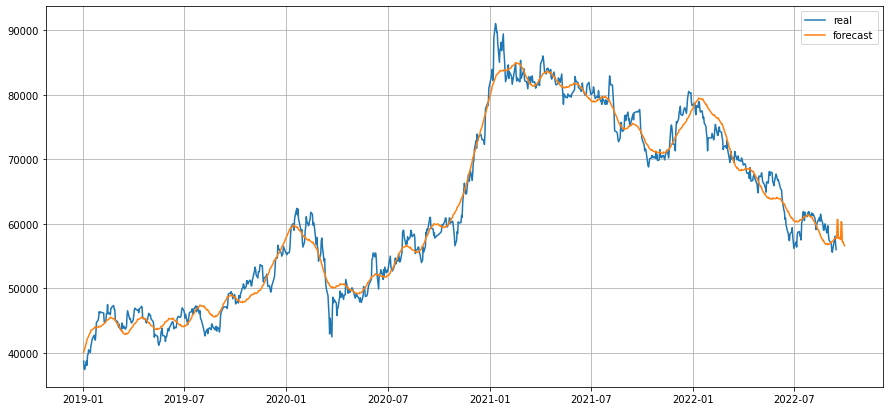

In [30]:
# 실제값과 예측값 시각화 1 
# 파란선: 실제 지수, 주황선: 예측 지수

plt.figure(figsize=(15,7))
plt.plot(stock_2019.index, stock_2019["종가"], label="real")
plt.plot(pred_2019["ds"], pred_2019["yhat"], label="forecast")
plt.grid(True)
plt.legend()
plt.show()

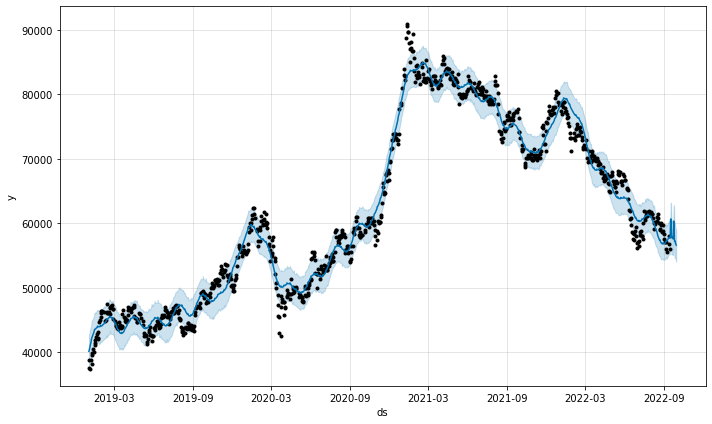

In [31]:
# 실제값과 예측값 시각화 2 
f1 = pro_2019.plot(pred_2019)

* 실제값과 예측값 사이에 차이가 있지만, 전체적인 추세는 비슷함

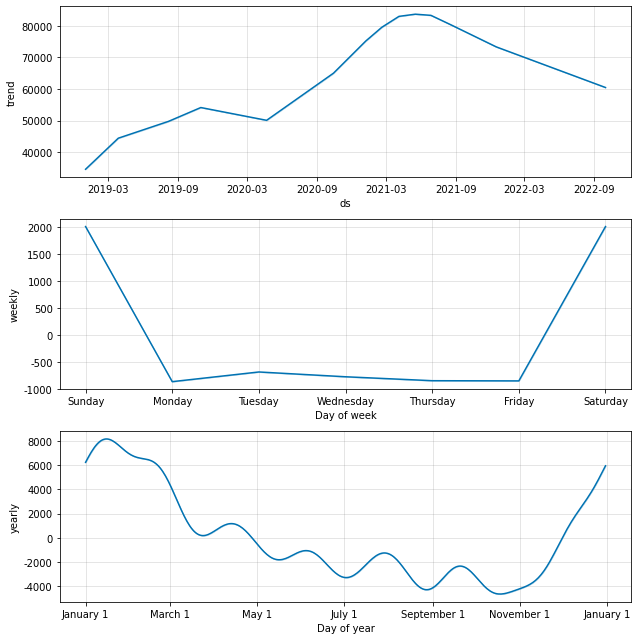

In [32]:
# 전체 기간 동안의 지수 추세와 주별, 연도별 계절성
f2 = pro_2019.plot_components(pred_2019)

* 2019~2022년 동안의 추세를 살펴보니, 코스피 지수가 3월 말에 많이 떨어지는 것이 확인됨
* 주중(월~금) 내내 지수가 마이너스임

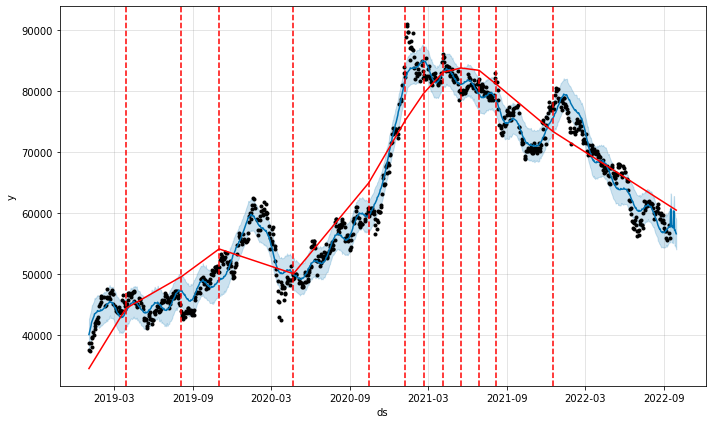

In [33]:
# 모델의 changepoint 확인
# 빨간 실선: 트렌드, 빨간 점선: 트렌드가 변화하는 changepoint
from prophet.plot import add_changepoints_to_plot

fig = pro_2019.plot(pred_2019)
a = add_changepoints_to_plot(fig.gca(), pro_2019, pred_2019)

In [34]:
# 2019~2022년 9월 15일까지의 데이터를 사용한 코스피 지수의 예측 결과
pred_2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-15:]

,ds,yhat,yhat_lower,yhat_upper
915,2022-09-16,57770.320318,55220.407254,60059.188786
916,2022-09-17,60658.653159,58204.572390,63230.452779
917,2022-09-18,60664.126910,58090.456947,63092.508266
918,2022-09-19,57771.920419,55177.541895,60222.703231
919,2022-09-20,57923.450471,55207.085760,60403.662873
920,2022-09-21,57788.774241,55142.667978,60452.600078
921,2022-09-22,57652.754346,55119.199816,60074.500176
922,2022-09-23,57568.922479,55057.806554,60246.284376
923,2022-09-24,60339.566417,57763.364373,62765.114151
924,2022-09-25,60227.395415,57680.357763,62807.875404


* 2019~2022년 9월 15일까지의 데이터를 사용한 코스피 지수의 예측 결과, 예측의 상한값과 하한값이 꽤나 큰 차이를 보임

## 4.2 2022년 코스피 지수만 사용한 예측

* 2022년 1월 1일 ~ 2022년 9월 15일 동안의 데이터만 사용해서 향후 15일의 코스피 지수를 예측함

In [35]:
# 예측하고자 하는 컬럼("y"), 날짜 컬럼("ds") 생성
kospi_2022 = stock_2022.copy()
kospi_2022['y'] = kospi_2022['종가']
kospi_2022['ds'] = kospi_2022.index

# 예측을 위한 prophet 모델 생성
pro_2022 = Prophet()
pro_2022.fit(kospi_2022)

# 향후 15일의 지수를 예측
future_2022 = pro_2022.make_future_dataframe(periods=15)
pred_2022 = pro_2022.predict(future_2022)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlb0g_5d/8z2h98v_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqlb0g_5d/x1ktej88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54765', 'data', 'file=/tmp/tmpqlb0g_5d/8z2h98v_.json', 'init=/tmp/tmpqlb0g_5d/x1ktej88.json', 'output', 'file=/tmp/tmpqlb0g_5d/prophet_modelwiv7kk9_/prophet_model-20230324154811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


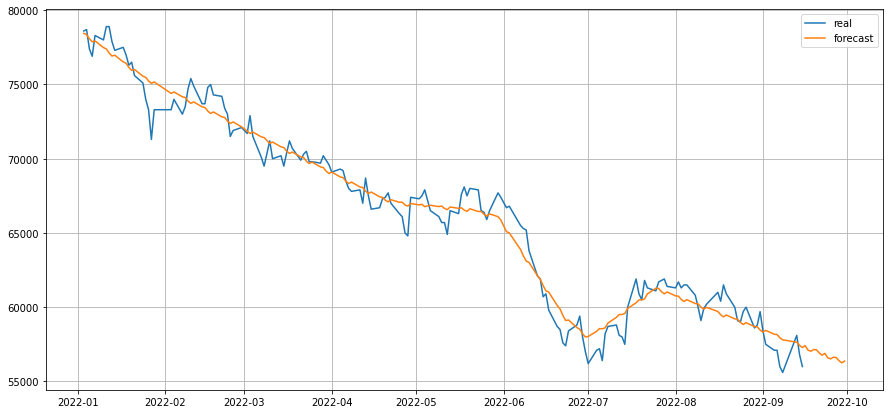

In [36]:
# 실제값과 예측값 시각화 1 
# 파란선: 실제 지수, 주황선: 예측 지수

plt.figure(figsize=(15,7))
plt.plot(stock_2022.index, stock_2022["종가"], label="real")
plt.plot(pred_2022["ds"], pred_2022["yhat"], label="forecast")
plt.grid(True)
plt.legend()
plt.show()

* 앞서 2019년 이후 코스피 지수를 사용했을 때보다, 실제값과 예측값의 차이가 더 큰 것으로 보임 <br>
(상대적으로 학습 데이터 수가 작아진 것이 원인이라고 판단됨)

* 하지만 예측값의 전체적인 추세는 실제값을 잘 따라가고 있음

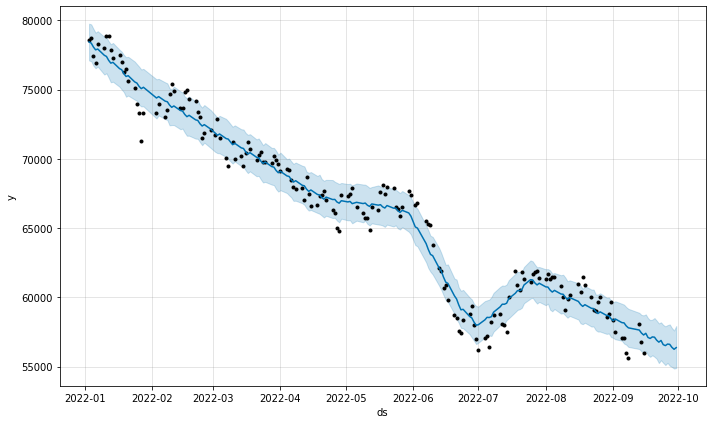

In [37]:
# 실제값과 예측값 시각화 2
f1 = pro_2022.plot(pred_2022)

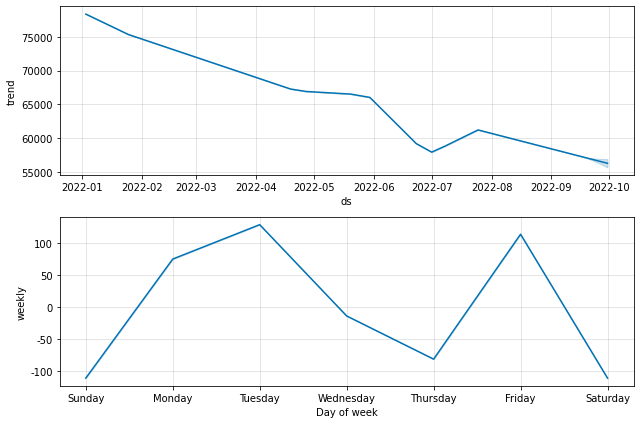

In [38]:
# 전체 기간 동안의 지수 추세와 주별, 연도별 계절성
fig2 = pro_2022.plot_components(pred_2022)

* 코스피 지수가 2022년 7월에 많이 떨어졌음
* 앞서 2019년 이후 데이터에서는 주중 내내 마이너스였지만, 2022년 데이터에서는 화요일과 금요일에 높고 목요일에 특히 많이 떨어지는 것을 확인할 수 있음

In [39]:
# 2022년(1/1~9/15)의 데이터를 사용한 코스피 지수의 예측 결과
pred_2022[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-15:]

,ds,yhat,yhat_lower,yhat_upper
173,2022-09-16,57405.757027,56139.679831,58771.408416
174,2022-09-17,57107.129015,55841.994059,58505.109927
175,2022-09-18,57033.344312,55704.875378,58357.084782
176,2022-09-19,57145.631688,55819.789739,58391.790164
177,2022-09-20,57125.568873,55709.887798,58507.845148
178,2022-09-21,56909.156805,55567.265710,58321.612734
179,2022-09-22,56767.890385,55256.733312,58123.074427
180,2022-09-23,56889.264532,55462.123460,58199.109944
181,2022-09-24,56590.636520,55277.349994,58010.607577
182,2022-09-25,56516.851817,55112.656692,57912.224843


## 4.3 2019년 이후 vs. 2022년 비교

* 2019년 이후(2019/1/1 ~ 2022/9/15) 데이터와 2022년(1/1 ~ 9/15) 데이터를 사용해 도출된 예측값들을 비교함
* yhat_x: 2019~2022 지수, yhat_y: 2022 지수를 반영한 예측값

In [40]:
# 예측값으로부터 마지막 20일간의 수치만 가져옴
df_2019 = pred_2019[['ds', 'yhat']].iloc[-20:]
df_2022 = pred_2022[['ds', 'yhat']].iloc[-20:]
df_2019 = df_2019.set_index('ds')
df_2022 = df_2022.set_index('ds')

In [41]:
forecast = pd.merge(df_2019, df_2022, how = 'inner', left_index = True, right_index = True)
forecast

,yhat_x,yhat_y
ds,,
2022-09-07,57220.760106,57942.141795
2022-09-08,57231.607723,57800.875376
2022-09-13,57792.150218,57642.061368
2022-09-14,57762.953796,57425.649300
2022-09-15,57738.497635,57284.382880
2022-09-16,57770.320318,57405.757027
2022-09-17,60658.653159,57107.129015
2022-09-18,60664.126910,57033.344312
2022-09-19,57771.920419,57145.631688


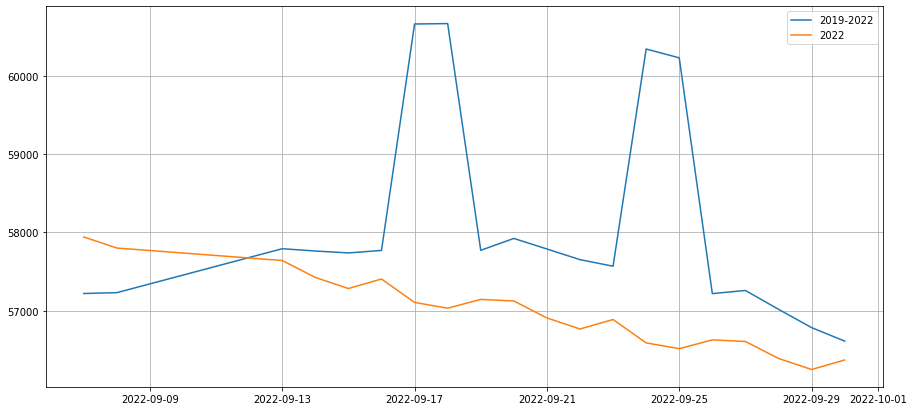

In [42]:
# 시각화하여 비교
plt.figure(figsize=(15,7))
plt.plot(forecast.index, forecast["yhat_x"], label="2019-2022")
plt.plot(forecast.index, forecast["yhat_y"], label="2022")
plt.grid(True)
plt.legend()
plt.show()

* 비교해보면, 9월 13일부터 9월 30일까지 2022년도의 코스피 지수를 통해 예측한 결과가 3년간의 지수를 통해 예측한 결과보다 모두 하위에 있음

# 정리

* 이동평균선을 살펴본 결과, 아직 장기이평선과 단기이평선 간 차이가 크므로 코스피 지수가 쉽게 반등하기는 힘들어 보임. 하지만 주가에 영향을 주는 요인은 무수히 많으므로, 시각화를 통한 예측 결과를 확신하긴 어려움
* fbprophet 패키지로 예측을 진행한 결과, 2019년 이후 3년간의 데이터와 2022년 데이터를 사용했을 때 예측값의 차이가 꽤 크게 나타남

# 참고 자료
> * [김태준, Python 완전정복 시리즈 2편 (wikidocs)](https://wikidocs.net/152788)
* [김영상, “2020년 11월 역사에 남을 코스피... 이런 상승은 전에 없었다”, 『머니투데이』, 2020년 11월 30일](https://news.mt.co.kr/mtview.php?no=2020113010233154269)